In [0]:
import gensim

In [0]:
from gensim.models import Word2Vec

In [0]:
import pandas as pd

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
file_csv = pd.read_csv('drive/My Drive/ForGensim/train.csv')

In [89]:
print(file_csv['text'][0])

Add another song to the Cita RomГЎntica playlist. 


In [0]:
intents = file_csv.intents.unique()

In [91]:
intents

array(['AddToPlaylist', 'BookRestaurant', 'GetWeather', 'PlayMusic',
       'RateBook', 'SearchCreativeWork', 'SearchScreeningEvent'],
      dtype=object)

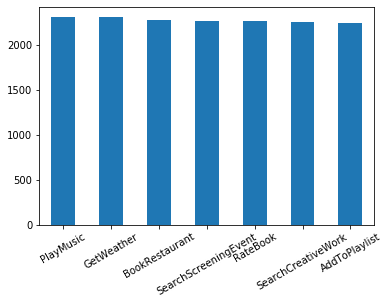

In [92]:
file_csv.intents.value_counts().plot(kind="bar", rot=30)

In [0]:
tokens = []
sentences = file_csv['text']

for sentence in sentences:
  tokens.append(sentence.split())

In [94]:
tokens

[['Add', 'another', 'song', 'to', 'the', 'Cita', 'RomГЎntica', 'playlist.'],
 ['add', 'clem', 'burke', 'in', 'my', 'playlist', 'Pre-Party', 'R&B', 'Jams'],
 ['Add', 'Live', 'from', 'Aragon', 'Ballroom', 'to', 'Trapeo'],
 ['add', 'Unite', 'and', 'Win', 'to', 'my', 'night', 'out'],
 ['Add', 'track', 'to', 'my', 'Digster', 'Future', 'Hits'],
 ['add', 'the', 'piano', 'bar', 'to', 'my', 'Cindy', 'Wilson'],
 ['Add', 'Spanish', 'Harlem', 'Incident', 'to', 'cleaning', 'the', 'house'],
 ['add',
  'The',
  'Greyest',
  'of',
  'Blue',
  'Skies',
  'in',
  'Indie',
  'EspaГ±ol',
  'my',
  'playlist'],
 ['Add',
  'the',
  'name',
  'kids',
  'in',
  'the',
  'street',
  'to',
  'the',
  'plylist',
  'New',
  'Indie',
  'Mix'],
 ['add', 'album', 'radar', 'latino'],
 ['Add', 'Tranquility', 'to', 'the', 'Latin', 'Pop', 'Rising', 'playlist.'],
 ['Add', 'd', 'flame', 'to', 'the', 'Dcode2016', 'playlist.'],
 ['Add', 'album', 'to', 'my', 'fairy', 'tales'],
 ['I',
  'need',
  'another',
  'artist',
  'in'

In [95]:
model = Word2Vec(tokens, size=200, window=10, min_count=3, workers=4)

2019-12-02 20:05:07,059 : INFO : collecting all words and their counts
2019-12-02 20:05:07,060 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-02 20:05:07,085 : INFO : PROGRESS: at sentence #10000, processed 91928 words, keeping 12208 word types
2019-12-02 20:05:07,096 : INFO : collected 16176 word types from a corpus of 142149 raw words and 15884 sentences
2019-12-02 20:05:07,097 : INFO : Loading a fresh vocabulary
2019-12-02 20:05:07,109 : INFO : effective_min_count=3 retains 3762 unique words (23% of original 16176, drops 12414)
2019-12-02 20:05:07,110 : INFO : effective_min_count=3 leaves 127303 word corpus (89% of original 142149, drops 14846)
2019-12-02 20:05:07,122 : INFO : deleting the raw counts dictionary of 16176 items
2019-12-02 20:05:07,123 : INFO : sample=0.001 downsamples 71 most-common words
2019-12-02 20:05:07,124 : INFO : downsampling leaves estimated 84297 word corpus (66.2% of prior 127303)
2019-12-02 20:05:07,133 : INFO : estimate

In [96]:
model.train(tokens, total_examples=len(tokens), epochs=500)

2019-12-02 20:05:13,433 : WARNING : Effective 'alpha' higher than previous training cycles
2019-12-02 20:05:13,436 : INFO : training model with 4 workers on 3762 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=10
2019-12-02 20:05:13,571 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-12-02 20:05:13,573 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-12-02 20:05:13,582 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-12-02 20:05:13,586 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-12-02 20:05:13,586 : INFO : EPOCH - 1 : training on 142149 raw words (84333 effective words) took 0.1s, 614590 effective words/s
2019-12-02 20:05:13,725 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-12-02 20:05:13,730 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-12-02 20:05:13,732 : INFO : worker thread finished; awaiting finish of 1 m

(42149466, 71074500)

In [97]:
model.most_similar('music', topn=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-12-02 20:09:38,531 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('stuff', 0.5719741582870483),
 ('record', 0.5654193162918091),
 ('songs', 0.5558643341064453),
 ('something', 0.5253204107284546),
 ('melody', 0.472892165184021)]

In [98]:
model.predict_output_word('add song to playlist')

[('Add', 0.15533687),
 ('Seven', 0.010090232),
 ('Key', 0.008982879),
 ('have', 0.007087077),
 ('playlist.', 0.0058962684),
 ('mujeres', 0.0053291437),
 ("80's", 0.0047355783),
 ('hombres', 0.00465509),
 ('fiesta', 0.0037063095),
 ('Love,', 0.003492185)]

In [99]:
file_csv


,text,intents
0,Add another song to the Cita RomГЎntica playli...,AddToPlaylist
1,add clem burke in my playlist Pre-Party R&B Jams,AddToPlaylist
2,Add Live from Aragon Ballroom to Trapeo,AddToPlaylist
3,add Unite and Win to my night out,AddToPlaylist
4,Add track to my Digster Future Hits,AddToPlaylist
...,...,...
15879,Is Across the Line playing at the closest movi...,SearchScreeningEvent
15880,Which animated movies are playing in the neigh...,SearchScreeningEvent
15881,Where is They Always Return at Dawn playing,SearchScreeningEvent
15882,What is the movie schedule in the neighborhood,SearchScreeningEvent


Попробуем удалить стоп-слова и посмотреть, что изменится


In [0]:
import nltk

In [0]:
from nltk.corpus import stopwords


In [0]:
def remove_stopwords(text):
  words = nltk.word_tokenize(text)
  stop_words = set(stopwords.words("english"))
  without_stop_words = [w for w in words if w not in stop_words]
  return without_stop_words

In [103]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [104]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
sentences_new = file_csv['text'].apply(lambda x : remove_stopwords(x))

In [106]:
file_csv['text']

0        Add another song to the Cita RomГЎntica playli...
1         add clem burke in my playlist Pre-Party R&B Jams
2                  Add Live from Aragon Ballroom to Trapeo
3                        add Unite and Win to my night out
4                      Add track to my Digster Future Hits
                               ...                        
15879    Is Across the Line playing at the closest movi...
15880    Which animated movies are playing in the neigh...
15881          Where is They Always Return at Dawn playing
15882       What is the movie schedule in the neighborhood
15883    Tell me when Howling II: Your Sister Is a Were...
Name: text, Length: 15884, dtype: object

In [107]:
sentences_new

0        [Add, another, song, Cita, RomГЎntica, playlis...
1        [add, clem, burke, playlist, Pre-Party, R, &, ...
2                    [Add, Live, Aragon, Ballroom, Trapeo]
3                                 [add, Unite, Win, night]
4                      [Add, track, Digster, Future, Hits]
                               ...                        
15879    [Is, Across, Line, playing, closest, movie, ho...
15880    [Which, animated, movies, playing, neighbourho...
15881         [Where, They, Always, Return, Dawn, playing]
15882                [What, movie, schedule, neighborhood]
15883    [Tell, Howling, II, :, Your, Sister, Is, Werew...
Name: text, Length: 15884, dtype: object

In [0]:
import numpy as np

In [0]:
sentences_new = np.array(sentences_new)

In [110]:
sentences_new

array([list(['Add', 'another', 'song', 'Cita', 'RomГЎntica', 'playlist', '.']),
       list(['add', 'clem', 'burke', 'playlist', 'Pre-Party', 'R', '&', 'B', 'Jams']),
       list(['Add', 'Live', 'Aragon', 'Ballroom', 'Trapeo']), ...,
       list(['Where', 'They', 'Always', 'Return', 'Dawn', 'playing']),
       list(['What', 'movie', 'schedule', 'neighborhood']),
       list(['Tell', 'Howling', 'II', ':', 'Your', 'Sister', 'Is', 'Werewolf', 'playing', '.'])],
      dtype=object)

In [0]:
tokens1 = []

for sentence in sentences_new:
  tokens1.append(sentence)

In [112]:
model1 = Word2Vec(tokens1, size=200, window=10, min_count=3, workers=4)

2019-12-02 20:11:35,683 : INFO : collecting all words and their counts
2019-12-02 20:11:35,684 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-02 20:11:35,706 : INFO : PROGRESS: at sentence #10000, processed 64597 words, keeping 10952 word types
2019-12-02 20:11:35,718 : INFO : collected 14189 word types from a corpus of 102475 raw words and 15884 sentences
2019-12-02 20:11:35,719 : INFO : Loading a fresh vocabulary
2019-12-02 20:11:35,851 : INFO : effective_min_count=3 retains 3618 unique words (25% of original 14189, drops 10571)
2019-12-02 20:11:35,852 : INFO : effective_min_count=3 leaves 89695 word corpus (87% of original 102475, drops 12780)
2019-12-02 20:11:35,865 : INFO : deleting the raw counts dictionary of 14189 items
2019-12-02 20:11:35,866 : INFO : sample=0.001 downsamples 70 most-common words
2019-12-02 20:11:35,867 : INFO : downsampling leaves estimated 66245 word corpus (73.9% of prior 89695)
2019-12-02 20:11:35,876 : INFO : estimated 

In [113]:
model1.train(tokens1, total_examples=len(tokens), epochs=500)

2019-12-02 20:12:23,345 : WARNING : Effective 'alpha' higher than previous training cycles
2019-12-02 20:12:23,346 : INFO : training model with 4 workers on 3618 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=10
2019-12-02 20:12:23,468 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-12-02 20:12:23,474 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-12-02 20:12:23,486 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-12-02 20:12:23,489 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-12-02 20:12:23,490 : INFO : EPOCH - 1 : training on 102475 raw words (66155 effective words) took 0.1s, 539480 effective words/s
2019-12-02 20:12:23,599 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-12-02 20:12:23,600 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-12-02 20:12:23,604 : INFO : worker thread finished; awaiting finish of 1 m

(33124288, 51237500)

In [114]:
model1.most_similar('weather', topn=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-12-02 20:17:11,179 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('humidity', 0.496013879776001),
 ('forecast', 0.4942648112773895),
 ('temperature', 0.4696580171585083),
 ('temperate', 0.4564307928085327),
 ('Francisco', 0.3873310089111328)]

In [115]:
model1.most_similar('music', topn=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('record', 0.5896725654602051),
 ('stuff', 0.5522068738937378),
 ('ep', 0.5164718627929688),
 ('anything', 0.5000259280204773),
 ('songs', 0.4851239323616028)]

In [116]:
model1.predict_output_word('add song to playlist')

[('put', 0.69705224),
 ('acoustic', 0.16536495),
 ('love', 0.07315715),
 ('classical', 0.028162716),
 ('album', 0.0042794677),
 ('w', 0.0012493965),
 ('andy', 0.0010557639),
 ('Latin', 0.00095478527),
 ('Add', 0.0009367628),
 ('Awards', 0.00068593735)]

In [117]:
model1.most_similar('songs', topn=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('melody', 0.5020672082901001),
 ('music', 0.4851239323616028),
 ('song', 0.4686596989631653),
 ('ep', 0.45211100578308105),
 ('hart', 0.4387497901916504)]